# Observing a galaxy with MICADO_Sci in wide-field MCAO mode

This notebook can be found in the [MICADO package on the IRDB Github repository](https://github.com/astronomyk/irdb/blob/master/MICADO/docs/static/)

In this example we will generate a basic galaxy object with the help of the ``ScopeSim_templates`` package.
We will then create a model of the ELT+MAORY+MICADO optical system using the ``MICADO_Sci`` package. 
The ``MICADO_Sci`` package has been optimised for speed so that the user can rapidly iterate on their science case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

%matplotlib inline
%config Completer.use_jedi = False

### Download the relevant scopesim instrument packages

We will need the ``MICADO_Sci`` package, as well as the support packages for ``Armazones``, the ``ELT``, and ``MAORY``

To view all available packages, use the ``sim.list_packages`` command

In [3]:
sim.download_package(["locations/Armazones.zip",
                      "telescopes/ELT.zip",
                      "instruments/MAORY.zip",
                      "instruments/MICADO_Sci.zip",])

['F:\\temp\\scopesim_fdr_notebooks\\Armazones.zip',
 'F:\\temp\\scopesim_fdr_notebooks\\ELT.zip',
 'F:\\temp\\scopesim_fdr_notebooks\\MAORY.zip',
 'F:\\temp\\scopesim_fdr_notebooks\\MICADO_Sci.zip']

### Set up on-sky source object

For ease of use we will use the helper function from ``ScopeSim_templates`` to create a two-layer spiral galaxy object.
The ``Source`` object contains two image layers (in ``<Source>.fields``) that each reference a unique spectrum.
The two layers correspond to the old and the new stellar populations of the galaxy.

In [2]:
gal = sim_tp.basic.galaxy.spiral_two_component(extent=16*u.arcsec, fluxes=(15, 15)*u.mag)

https://www.univie.ac.at/simcado/scopesim_templates/spiral_two_component.fits


Here we can see what is contained in the ``.fields`` and ``.spectra`` lists of the ``Source`` object

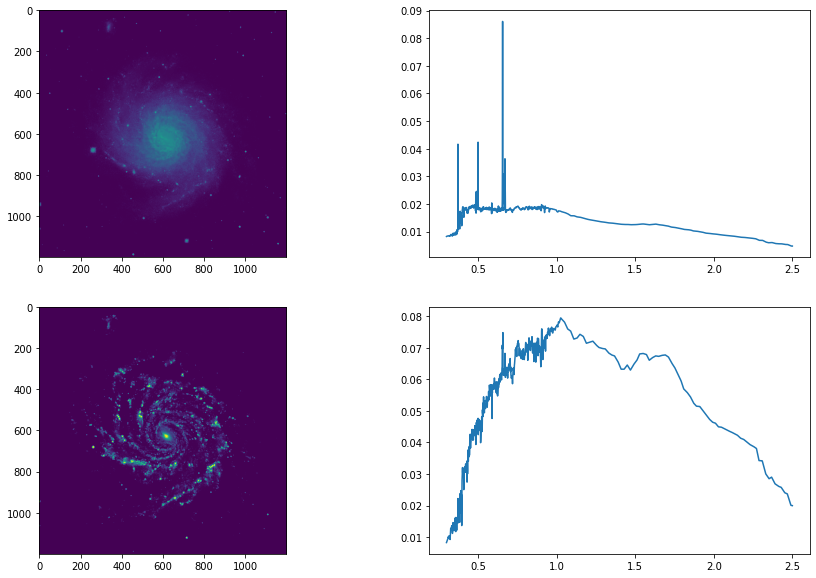

In [3]:
wave = np.linspace(0.3, 2.5, 2201) * u.um
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(gal.fields[0].data)
plt.subplot(222)
plt.plot(wave, gal.spectra[0](wave))
plt.subplot(223)
plt.imshow(gal.fields[1].data)
plt.subplot(224)
plt.plot(wave, gal.spectra[1](wave))

### Set up the MICADO_Sci system for MCAO 4mas J-band observations

The next step is to create a model of MICADO in memory. 
First we need to generate a set of commands that we can manipulate. 
Once we have these we can create a model of the optical system.

We use the ``UserCommands`` class and tell it to look for the ``MICADO_Sci`` package.
At the same time we set the observing modes to use. 
In this case we want ``MCAO`` and the 4mas per pixel wide-field optics (``IMG_4mas``)

In [5]:
cmd = sim.UserCommands(use_instrument="MICADO_Sci", set_modes=["SCAO", "IMG_4mas"])

We can update many of the observation parameters using the "!-bang" string syntax to access the values inside the hierarchical nested-dictionary structure of the ``UserCommands`` object.

Here we set the filter to the J-band, exposure length (DIT) to 60 seconds and number of exposures (DIT) to 1.
We can pass these parameters either as a dictionary using the ``.update(properties={...})`` method, or individually using normal dictionary notation with the "!-bang" strings.

As the ``MICADO_Sci`` package uses a configurable detector window, rather than the full (static) MICADO detector array, we can set the width and height of this detector window using ``!DET.width`` and ``!DET.height``:

In [7]:
cmd.update(properties={"!OBS.filter_name": "J", "!OBS.ndit": 1, "!OBS.dit": 60})

cmd["!DET.width"] = 2048     # pixel
cmd["!DET.height"] = 1024

Now that we have the commands set, we create the MICADO optical model

In [8]:
micado = sim.OpticalTrain(cmd)

Observing and reading out the detectors is also a simple operation

In [9]:
micado.observe(gal)
hdus = micado.readout()

Preparing 1 FieldOfViews


The output of a simulation is a list of ``fits.HDUList`` objects.
One ``HDUList`` for each detector plane.
In MICADO there is only 1 detector plane, but the class interface still requires that this single ``HDUList`` be placed in another list.

We can view the output of our custom Detecotr window like we would for any regular fits image in Python

Alternatively we could save the readout file to disk with the parameter ``filename=``:

    micado.readout(filename="my_galaxy.fits")

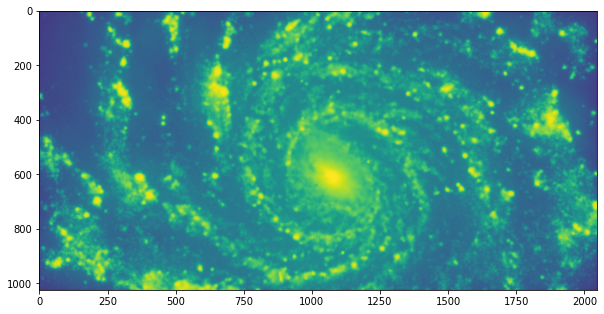

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(hdus[0][1].data, norm=LogNorm())